# Kombination von Wetterdaten und Krankheitsausbreitung

In [4]:
pip install requests pandas matplotlib seaborn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Params
start_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")  # Letzte 30 Tage
end_date = (datetime.now()- timedelta(days=1)).strftime("%Y-%m-%d")
interval = "24H"  # Tägliche Daten

# Location
latitude = "-1.406"
longitude = "35.014"
timezone = "Africa/Nairobi"

# API-URL
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max&timezone={timezone}"

# API-Request
response = requests.get(url)

# Check API-Response
if response.status_code == 200:
    data = response.json()
    print("Wetterdaten von " + timezone + " erfolgreich abgerufen!")
    print(data)    
else:
    print(f"Fehler {response.status_code}: {response.text}")


Wetterdaten von Africa/Nairobi erfolgreich abgerufen!
{'latitude': -1.4411248, 'longitude': 35.031647, 'generationtime_ms': 0.15425682067871094, 'utc_offset_seconds': 10800, 'timezone': 'Africa/Nairobi', 'timezone_abbreviation': 'GMT+3', 'elevation': 1603.0, 'daily_units': {'time': 'iso8601', 'temperature_2m_max': '°C', 'temperature_2m_min': '°C', 'precipitation_sum': 'mm', 'wind_speed_10m_max': 'km/h'}, 'daily': {'time': ['2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-14', '2025-03-15', '2025-03-16'], 'temperature_2m_max': [26.2, 29.4, 27.1, 28.5, 31.9, 30.7, 18.4], 'temperature_2m_min': [17.1, 16.1, 16.5, 15.7, 15.0, 16.1, 16.9], 'precipitation_sum': [11.3, 1.8, 4.5, 0.1, 0.2, 1.0, None], 'wind_speed_10m_max': [20.2, 11.9, 19.6, 15.2, 18.4, 19.4, 1.5]}}


In [6]:
print(data['daily'])

{'time': ['2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-14', '2025-03-15', '2025-03-16'], 'temperature_2m_max': [26.2, 29.4, 27.1, 28.5, 31.9, 30.7, 18.4], 'temperature_2m_min': [17.1, 16.1, 16.5, 15.7, 15.0, 16.1, 16.9], 'precipitation_sum': [11.3, 1.8, 4.5, 0.1, 0.2, 1.0, None], 'wind_speed_10m_max': [20.2, 11.9, 19.6, 15.2, 18.4, 19.4, 1.5]}


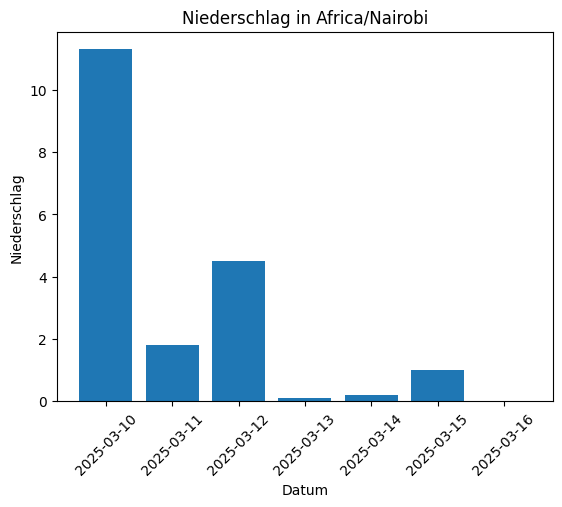

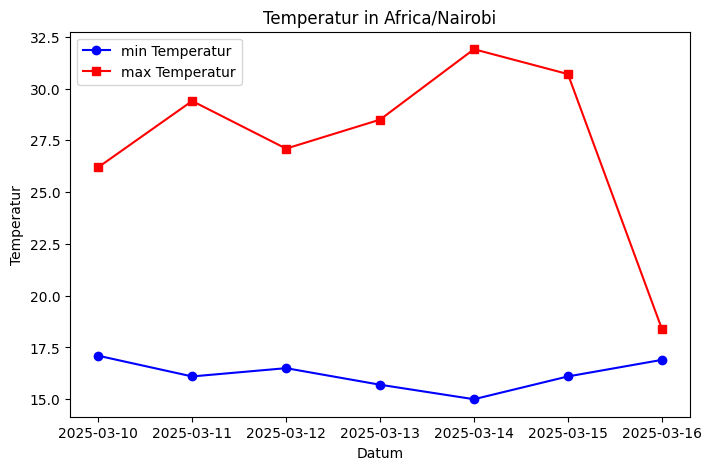

In [7]:
import matplotlib.pyplot as plt

# Extract relevant data 
timeline = data['daily']['time']
precipitation_sum = data['daily']['precipitation_sum']
temperature_min = data['daily']['temperature_2m_min']
temperature_max = data['daily']['temperature_2m_max']

# If no value is given for a specific date, the value "None" will be replace with 0
precipitation_sum = [0 if value == None else value for value in precipitation_sum]

# Niederschlag
plt.bar(timeline, precipitation_sum)
plt.title('Niederschlag in ' + timezone)
plt.xlabel('Datum')
plt.xticks(rotation=45)
plt.ylabel('Niederschlag')
plt.show()

# Temperatur
plt.figure(figsize=(8, 5))
plt.plot(timeline, temperature_min, marker='o', color='blue', label='min Temperatur')
plt.plot(timeline, temperature_max, marker='s', color='red', label='max Temperatur')

plt.title('Temperatur in ' + timezone)
plt.xlabel('Datum')
plt.ylabel('Temperatur')
plt.legend()
plt.show()


Erste Datensätze:
    Year  NumericValue       Low      High
4   2010      66.53364  48.90856  88.47648
7   2011      68.71365  50.83849  90.86659
0   2012      70.55896  51.44225  94.39272
2   2013      72.08089  52.04616  96.28303
3   2014      71.61824  52.30612  96.02439
5   2015      69.36560  50.43921  93.64701
10  2016      64.79533  45.69992  89.20984
6   2017      64.07433  44.49336  89.85021
9   2018      61.17636  42.34897  85.94425
8   2019      58.68428  40.56339  81.95962
1   2020      61.86130  45.18314  82.96898


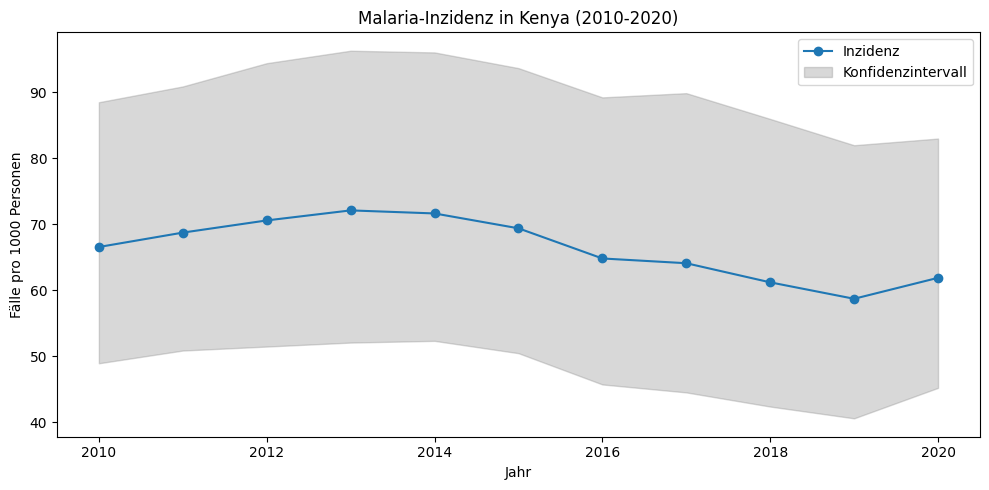

In [8]:
# Basis-URL der GHO OData API für den Indikator "Malaria incidence"
url = "https://ghoapi.azureedge.net/api/MALARIA_EST_INCIDENCE"

# Beispiel: Filter für Kenya und Daten von 2010 bis 2020
filter_str = "SpatialDim eq 'KEN' and date(TimeDimensionBegin) ge 2010-01-01 and date(TimeDimensionBegin) lt 2021-01-01"
params = {"$filter": filter_str}

# API-Request
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    records = data.get('value', [])
    
    if records:
        df = pd.DataFrame(records)
        # Konvertiere das Jahr (TimeDimensionBegin) in ein Datumsformat und extrahiere das Jahr
        df['Year'] = pd.to_datetime(df['TimeDimensionBegin']).dt.year
        df.sort_values(by='Year', inplace=True)
        
        print("Erste Datensätze:")
        print(df[['Year', 'NumericValue', 'Low', 'High']])
        
        # Visualisierung
        plt.figure(figsize=(10, 5))
        plt.plot(df['Year'], df['NumericValue'], marker='o', label='Inzidenz')
        plt.fill_between(df['Year'], df['Low'], df['High'], color='gray', alpha=0.3, label='Konfidenzintervall')
        plt.title("Malaria-Inzidenz in Kenya (2010-2020)")
        plt.xlabel("Jahr")
        plt.ylabel("Fälle pro 1000 Personen")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Keine Datensätze gefunden. Prüfe den Filter oder die Dimensionen.")
else:
    print(f"Fehler {response.status_code}: {response.text}")
